In [1]:
!pip install torch torchvision matplotlib seaborn scikit-learn scipy tqdm --quiet

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.2 MB/s eta 0:00:00


In [2]:
class VOCClassificationDataset(Dataset):
    def __init__(self, year='2007', image_set='train', transform=None):
        self.voc = VOCDetection(root='./data', year=year, image_set=image_set, download=True)
        self.transform = transform
        self.samples = []

        for img, target in self.voc:
            objects = target['annotation']['object']
            if isinstance(objects, list):
                label = objects[0]['name']
            else:
                label = objects['name']
            self.samples.append((img, label))

        self.classes = sorted(list(set(label for _, label in self.samples)))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label


In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

voc_2007 = VOCClassificationDataset(year='2007', image_set='train', transform=transform)
voc_2012 = VOCClassificationDataset(year='2012', image_set='train', transform=transform)

all_classes = sorted(list(set(voc_2007.classes + voc_2012.classes)))
class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
voc_2007.class_to_idx = voc_2012.class_to_idx = class_to_idx
voc_2007.classes = voc_2012.classes = all_classes

combined_dataset = ConcatDataset([voc_2007, voc_2012])
num_classes = len(all_classes)

train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 460M/460M [00:18<00:00, 24.2MB/s]
100%|██████████| 2.00G/2.00G [01:21<00:00, 24.4MB/s]


In [4]:
class BestCNN(nn.Module):
    def __init__(self, num_classes):
        super(BestCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchvision import transforms, models
model = models.resnet18(weights='IMAGENET1K_V1')  # Pretrained
for param in model.parameters():
    param.requires_grad = False  # Freeze base

# Replace classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

epochs = 10
train_losses, train_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    avg_acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%")


Epoch 1/10: 100%|██████████| 206/206 [00:16<00:00, 12.85it/s]


Epoch 1 - Loss: 2.0671, Accuracy: 38.24%


Epoch 2/10: 100%|██████████| 206/206 [00:15<00:00, 13.13it/s]


Epoch 2 - Loss: 1.6651, Accuracy: 48.55%


Epoch 3/10: 100%|██████████| 206/206 [00:15<00:00, 13.38it/s]


Epoch 3 - Loss: 1.5819, Accuracy: 50.87%


Epoch 4/10: 100%|██████████| 206/206 [00:15<00:00, 13.35it/s]


Epoch 4 - Loss: 1.5375, Accuracy: 51.51%


Epoch 5/10: 100%|██████████| 206/206 [00:16<00:00, 12.85it/s]


Epoch 5 - Loss: 1.4992, Accuracy: 53.26%


Epoch 6/10: 100%|██████████| 206/206 [00:15<00:00, 13.34it/s]


Epoch 6 - Loss: 1.4836, Accuracy: 53.26%


Epoch 7/10: 100%|██████████| 206/206 [00:15<00:00, 13.32it/s]


Epoch 7 - Loss: 1.4458, Accuracy: 54.27%


Epoch 8/10: 100%|██████████| 206/206 [00:15<00:00, 12.92it/s]


Epoch 8 - Loss: 1.4364, Accuracy: 54.53%


Epoch 9/10: 100%|██████████| 206/206 [00:15<00:00, 13.40it/s]


Epoch 9 - Loss: 1.4145, Accuracy: 55.31%


Epoch 10/10: 100%|██████████| 206/206 [00:15<00:00, 13.34it/s]

Epoch 10 - Loss: 1.4010, Accuracy: 56.10%


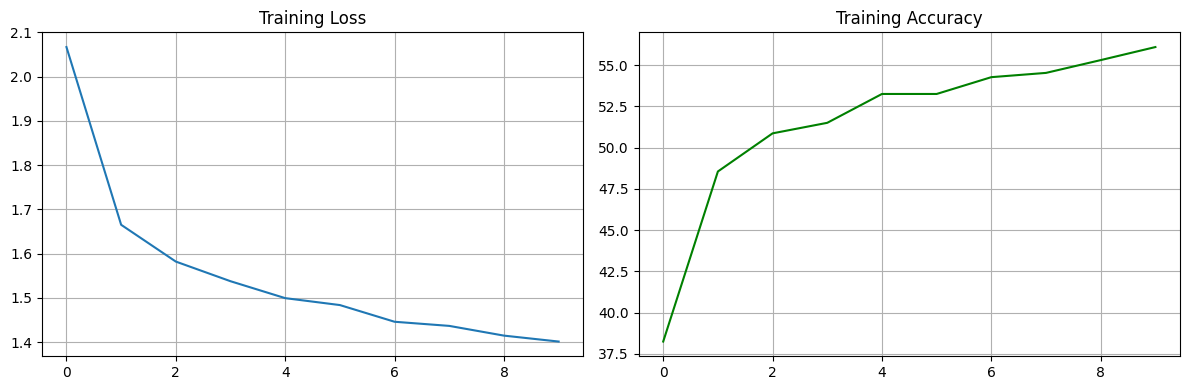

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.grid()

plt.tight_layout()
plt.show()


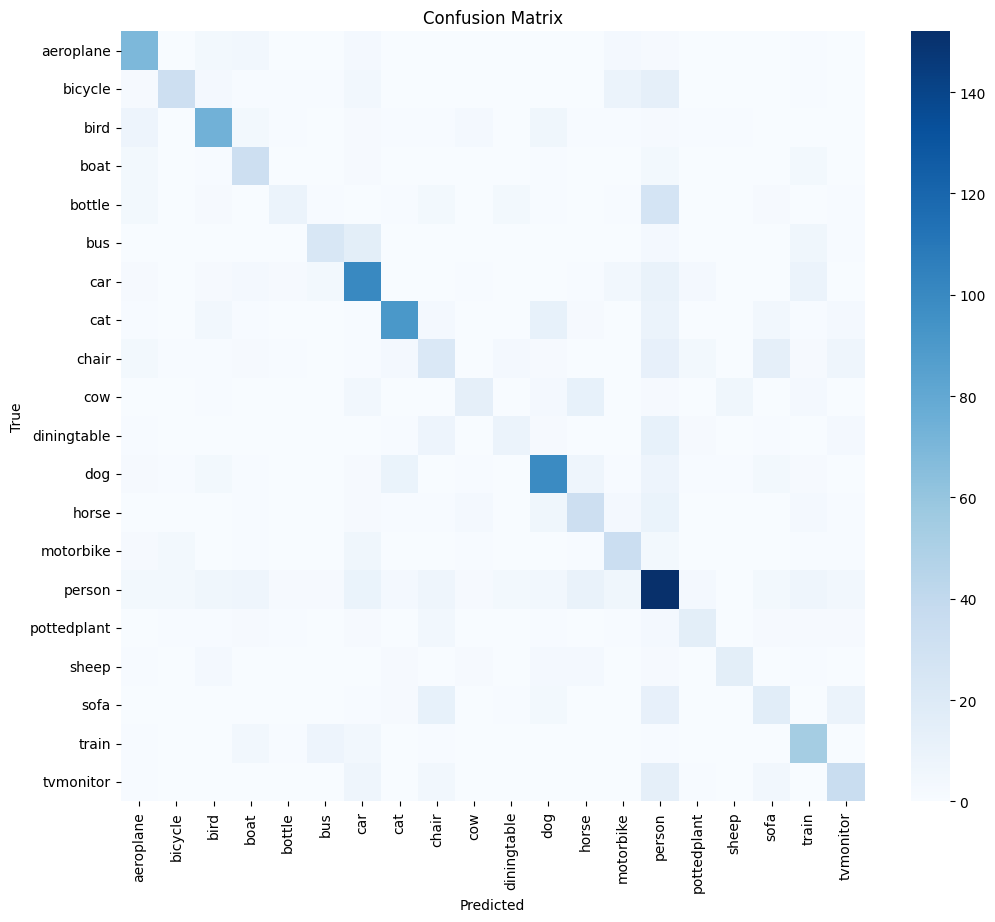

              precision    recall  f1-score   support

   aeroplane       0.65      0.79      0.72        87
     bicycle       0.75      0.47      0.58        70
        bird       0.69      0.70      0.69       106
        boat       0.50      0.67      0.57        49
      bottle       0.50      0.16      0.24        57
         bus       0.60      0.48      0.53        50
         car       0.59      0.70      0.64       143
         cat       0.79      0.68      0.73       134
       chair       0.32      0.28      0.30        80
         cow       0.52      0.30      0.38        46
 diningtable       0.43      0.23      0.30        39
         dog       0.68      0.69      0.69       144
       horse       0.46      0.52      0.49        64
   motorbike       0.53      0.62      0.57        55
      person       0.50      0.62      0.55       244
 pottedplant       0.52      0.41      0.46        39
       sheep       0.67      0.48      0.56        33
        sofa       0.31    

In [10]:
model.eval()
true_labels, pred_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, xticklabels=all_classes, yticklabels=all_classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, pred_labels, target_names=all_classes))


In [11]:
torch.save(model.state_dict(), "resnet_pascal_voc.pth")
model.load_state_dict(torch.load("resnet_pascal_voc.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

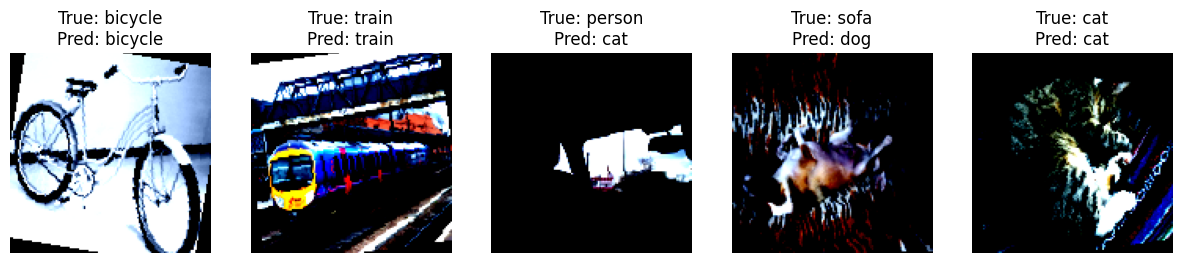

In [13]:
import random
def show_samples(dataset, class_names, n=5):
    model.eval()
    fig, axs = plt.subplots(1, n, figsize=(15, 4))
    for i in range(n):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        input_img = img.unsqueeze(0).to(device)
        pred = model(input_img)
        pred_label = torch.argmax(pred).item()

        axs[i].imshow(img.permute(1, 2, 0).numpy())
        axs[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred_label]}")
        axs[i].axis('off')

    plt.show()

show_samples(test_dataset, all_classes)


In [14]:
from scipy.stats import ttest_rel, f_oneway
from statsmodels.stats.proportion import proportions_ztest
from collections import defaultdict
import numpy as np

# Convert to NumPy arrays
true_array = np.array(true_labels)
pred_array = np.array(pred_labels)

# ✅ Z-Test: Compare proportions of correct vs incorrect predictions
correct = np.sum(true_array == pred_array)
incorrect = len(true_array) - correct
count = np.array([correct, incorrect])
nobs = np.array([len(true_array), len(true_array)])
z_stat, z_pval = proportions_ztest(count, nobs)

# ✅ T-Test: Compare mean of true vs predicted labels
t_stat, t_pval = ttest_rel(true_array, pred_array)

# ✅ ANOVA: Compare accuracy across classes
class_acc = defaultdict(list)
for true, pred in zip(true_array, pred_array):
    class_acc[true].append(int(true == pred))

if len(class_acc) >= 2:
    f_stat, f_pval = f_oneway(*class_acc.values())
else:
    f_stat, f_pval = None, None

# ✅ Display Results
print("=== Z-Test (Correct vs Incorrect Predictions) ===")
print(f"Z-Statistic: {z_stat:.4f}, p-value: {z_pval:.4f}")
print("Significant Difference" if z_pval < 0.05 else "No Significant Difference")

print("\n=== T-Test (True vs Predicted Labels) ===")
print(f"T-Statistic: {t_stat:.4f}, p-value: {t_pval:.4f}")
print("Significant Difference" if t_pval < 0.05 else "No Significant Difference")

print("\n=== ANOVA Test (Accuracy across Classes) ===")
if f_stat is not None:
    print(f"F-Statistic: {f_stat:.4f}, p-value: {f_pval:.4f}")
    print("Significant Difference" if f_pval < 0.05 else "No Significant Difference")
else:
    print("Not enough class groups to perform ANOVA.")


=== Z-Test (Correct vs Incorrect Predictions) ===
Z-Statistic: 7.8827, p-value: 0.0000
Significant Difference

=== T-Test (True vs Predicted Labels) ===
T-Statistic: -2.5458, p-value: 0.0110
Significant Difference

=== ANOVA Test (Accuracy across Classes) ===
F-Statistic: 11.1719, p-value: 0.0000
Significant Difference


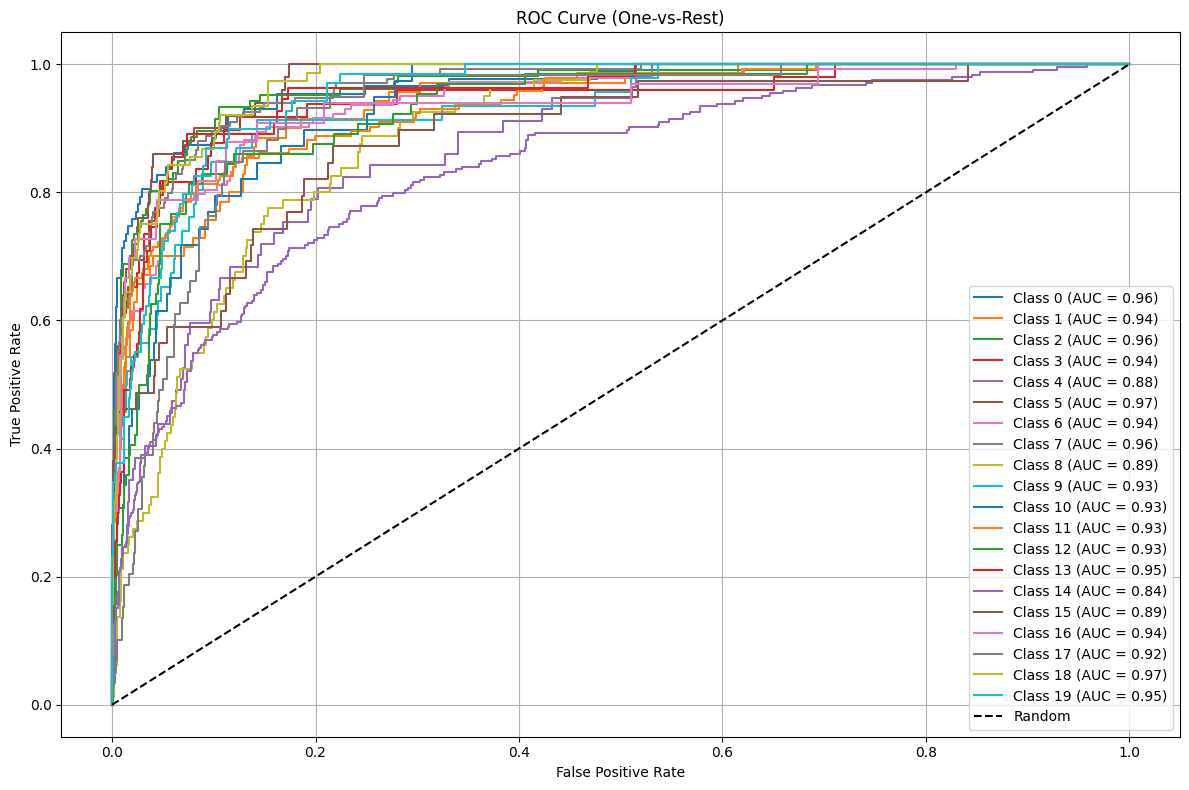

Macro Average AUC Score: 0.9323


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predicted probabilities (softmax outputs)
model.eval()
all_probs = []
all_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)  # Raw logits
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_true.extend(labels.numpy())

# 2. Convert to NumPy arrays
all_probs = np.array(all_probs)
all_true = np.array(all_true)

# 3. Binarize the true labels for multiclass ROC (One-vs-Rest)
true_binarized = label_binarize(all_true, classes=list(range(num_classes)))

# 4. Plot ROC Curve per class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], all_probs[:, i])
    roc_auc[i] = roc_auc_score(true_binarized[:, i], all_probs[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Optional: Print average AUC score
macro_auc = roc_auc_score(true_binarized, all_probs, average='macro')
print(f"Macro Average AUC Score: {macro_auc:.4f}")
